$\textbf{ANALYSIS FOR THE VEHICLES SERVICES DATASET}$

This dataset proves the customer' vehicle service data for a particular garage. This dataset was part of the final data cleaning project for the Udemy course titled "Data Science A-Z: Hands-On Exercises & ChatGPT Prize [$2025$]" by Kirill Eremenko, SuperDataScience Team and Ligency Team. It gives the service cost for servicing the vehicles in 2014, 2015 and an estimated cost for 2016. For this analysis, I will perform some additional checks to make sure the data is clean and then ignore the given estimated cost for 2016 to  build my own model to estimate it.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')



In [2]:
data = pd.read_csv('../vehicle_services_cleaned.csv')
# data.sort_values(by = 'RowNumber', inplace=True)
data

,RowNumber,CustomerID,CustomerSince,Vehicle,2014,2015,2016E
0,220894,2755739,2001-04-09,2007 Porsche Boxster,605.32,647.87,700.02
1,220895,2755740,2013-11-10,1998 Mitsubishi Diamante,360.45,798.80,352.89
2,220896,2755741,2009-04-12,2000 Pagani Zonda,638.13,347.64,265.26
3,220897,2755742,2003-02-18,2010 Lada 110,118.88,364.18,278.35
4,220898,2755743,2006-01-07,2004 Mercedes-Benz SL,537.90,589.06,404.05
...,...,...,...,...,...,...,...
1049993,220889,2755734,2012-07-24,2010 Citroen C4,81.19,348.58,453.49
1049994,220890,2755735,2014-10-05,1993 Fiat Uno,442.54,265.68,252.88
1049995,220891,2755736,2008-02-08,2011 Nissan X-Trail,8.73,525.51,50.09
1049996,220892,2755737,2009-02-08,1999 Renault Espace,379.69,684.26,7.49


Checking datatypes:

In [3]:
data.dtypes

RowNumber          int64
CustomerID         int64
CustomerSince     object
Vehicle           object
2014             float64
2015             float64
2016E            float64
dtype: object

COnverting the CustomerSince column into a datetime object:

In [4]:
data['CustomerSince'] = pd.to_datetime(data['CustomerSince'])
data.dtypes

RowNumber                 int64
CustomerID                int64
CustomerSince    datetime64[ns]
Vehicle                  object
2014                    float64
2015                    float64
2016E                   float64
dtype: object

$\textbf{CLEANING THE DATA: }$

The above data has been partially cleaned in the ETL process. Two rows were excluded in this process as explained below. Furthermore, other errors were found in the data in the ETL process yet were not excluded in the ETL process. They will be excluded within Python as given below. The rows with the errors are all stored under project_name -> Analysis -> errors.

$\textit{Exclusion 1:}$ Row was excluded in the ETL process as it had an additional column: 

In [5]:
excluded_row_1 = pd.read_csv('../errors/automatically_excluded_errors/bad_records.txt')
excluded_row_1

,CustomerID,CustomerSince,Vehicle,2014,2015,2016E,Column 6
0,2738818,2014-01-01,2009 Chevrolet Traverse,118.0,1.0,122.55,725.89


$\textit{Exclusion 2:}$ Row was excluded in SQL as the data for the '2015' column was invalid:

In [6]:
excluded_row_2 = pd.read_csv('../errors/manually_excluded_errors/invalid_2015_data.csv')
# print(excluded_row_2.head())
# excluded_row_2.drop(labels=['Column 6'], axis=1, inplace=True) # dropping the additional column since it serves no purpose
excluded_row_2

,RowNumber,CustomerID,CustomerSince,Vehicle,2014,2015,2016E,Column 6
0,676802,3211647,2004-12-21,1996 Daewoo Brougham,413.92,781$37,175.8,NaN


$\textit{Exclusion 3:}$ Rows to be excluded as they had identical CustomerID:

In [7]:
ID_count = data.CustomerID.value_counts(sort=True)
ID_count

3490750    2
3455698    1
3455732    1
3455733    1
3455734    1
          ..
3105743    1
3105744    1
3105745    1
3105746    1
2755738    1
Name: CustomerID, Length: 1049997, dtype: int64

In [8]:
print("There are {} occurences of customers with CustomerID = {} although it must be unique.".format(ID_count.values[0], ID_count.index[0]))

There are 2 occurences of customers with CustomerID = 3490750 although it must be unique.


In [9]:
excluded_row_3 = pd.read_csv('../errors/manually_excluded_errors/duplicate_CustomerID.csv')
excluded_row_3

,RowNumber,CustomerID,CustomerSince,Vehicle,2014,2015,2016E
0,955904,3490750,2006-05-17,2007 Tata Sumo,349.88,340.62,517.20
1,955905,3490750,2006-01-22,2004 Volkswagen Touran,735.77,741.23,314.09


Removing these rows from the main data:

In [10]:
data = data[data['CustomerID'] != excluded_row_3.CustomerID.values[0]]
data

,RowNumber,CustomerID,CustomerSince,Vehicle,2014,2015,2016E
0,220894,2755739,2001-04-09,2007 Porsche Boxster,605.32,647.87,700.02
1,220895,2755740,2013-11-10,1998 Mitsubishi Diamante,360.45,798.80,352.89
2,220896,2755741,2009-04-12,2000 Pagani Zonda,638.13,347.64,265.26
3,220897,2755742,2003-02-18,2010 Lada 110,118.88,364.18,278.35
4,220898,2755743,2006-01-07,2004 Mercedes-Benz SL,537.90,589.06,404.05
...,...,...,...,...,...,...,...
1049993,220889,2755734,2012-07-24,2010 Citroen C4,81.19,348.58,453.49
1049994,220890,2755735,2014-10-05,1993 Fiat Uno,442.54,265.68,252.88
1049995,220891,2755736,2008-02-08,2011 Nissan X-Trail,8.73,525.51,50.09
1049996,220892,2755737,2009-02-08,1999 Renault Espace,379.69,684.26,7.49


$\textit{Exclusion 4:}$ Row excluded as customer was a member since significantly before othere customers:

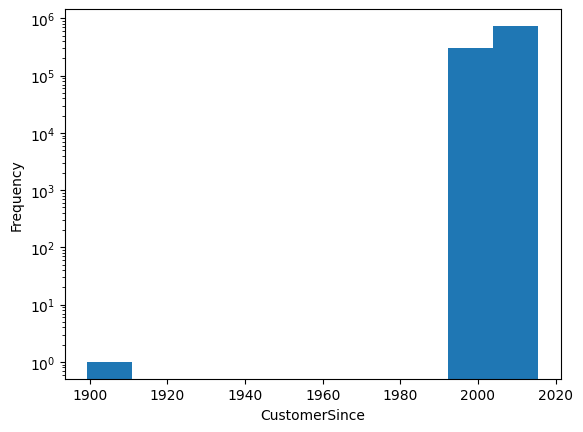

The earliest customer is from the date 1899-04-30 00:00:00


In [11]:
plt.hist(data.CustomerSince, log=True)

plt.xlabel('CustomerSince')
plt.ylabel('Frequency')
plt.show()

print("The earliest customer is from the date {}".format(data.CustomerSince.min()))

One customer has been a memeber of this garage since 1899, which is much earlier than the other customers. This was most likely a date entry error. Therefore this row will be excluded.

In [12]:
excluded_row_4 = pd.read_csv('../errors/manually_excluded_errors/old_data_point.csv')
excluded_row_4

,RowNumber,CustomerID,CustomerSince,Vehicle,2014,2015,2016E
0,407988,2942833,1899-04-30,2001 Jaguar XJR,610.33,460.45,156.12


In [13]:
data = data[data['CustomerID'] != excluded_row_4.CustomerID.values[0]]
data

,RowNumber,CustomerID,CustomerSince,Vehicle,2014,2015,2016E
0,220894,2755739,2001-04-09,2007 Porsche Boxster,605.32,647.87,700.02
1,220895,2755740,2013-11-10,1998 Mitsubishi Diamante,360.45,798.80,352.89
2,220896,2755741,2009-04-12,2000 Pagani Zonda,638.13,347.64,265.26
3,220897,2755742,2003-02-18,2010 Lada 110,118.88,364.18,278.35
4,220898,2755743,2006-01-07,2004 Mercedes-Benz SL,537.90,589.06,404.05
...,...,...,...,...,...,...,...
1049993,220889,2755734,2012-07-24,2010 Citroen C4,81.19,348.58,453.49
1049994,220890,2755735,2014-10-05,1993 Fiat Uno,442.54,265.68,252.88
1049995,220891,2755736,2008-02-08,2011 Nissan X-Trail,8.73,525.51,50.09
1049996,220892,2755737,2009-02-08,1999 Renault Espace,379.69,684.26,7.49


$\textit{Exclusion 5:}$ Row excluded as '2014' column had a outlier:

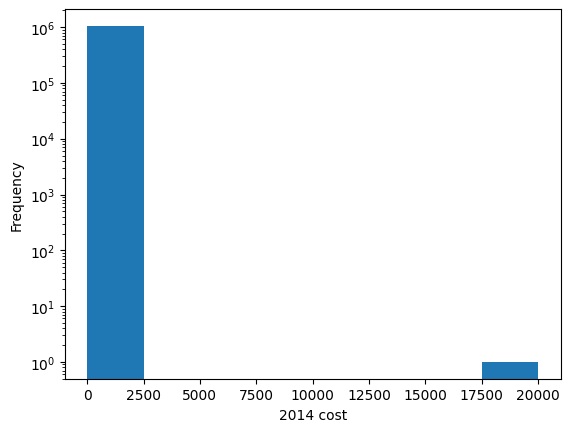

In [14]:
plt.hist(data['2014'], bins = 8, log=True)
plt.xlabel('2014 cost')
plt.ylabel('Frequency')
plt.show()

We see that all but one data point has a 2014 cost between $0 and $2500. Therefore, this outlier must be discarded

In [15]:
excluded_row_5 = pd.read_csv('../errors/manually_excluded_errors/2014_column_outlier.csv')
excluded_row_5

,RowNumber,CustomerID,CustomerSince,Vehicle,2014,2015,2016E
0,902805,3437651,2009-06-27,2005 Holden Combo,20000,783.96,122.86


In [16]:
data = data[data['2014'] != excluded_row_5['2014'].values[0]]
data

,RowNumber,CustomerID,CustomerSince,Vehicle,2014,2015,2016E
0,220894,2755739,2001-04-09,2007 Porsche Boxster,605.32,647.87,700.02
1,220895,2755740,2013-11-10,1998 Mitsubishi Diamante,360.45,798.80,352.89
2,220896,2755741,2009-04-12,2000 Pagani Zonda,638.13,347.64,265.26
3,220897,2755742,2003-02-18,2010 Lada 110,118.88,364.18,278.35
4,220898,2755743,2006-01-07,2004 Mercedes-Benz SL,537.90,589.06,404.05
...,...,...,...,...,...,...,...
1049993,220889,2755734,2012-07-24,2010 Citroen C4,81.19,348.58,453.49
1049994,220890,2755735,2014-10-05,1993 Fiat Uno,442.54,265.68,252.88
1049995,220891,2755736,2008-02-08,2011 Nissan X-Trail,8.73,525.51,50.09
1049996,220892,2755737,2009-02-08,1999 Renault Espace,379.69,684.26,7.49


This completes all the data cleaning. I do not check for NA values in python as this has been taken care of when loading the data onto the SQL database.

$\textbf{Fitting a model to estimate the 2016 prices: }$

In [17]:
# Splitting the data into training and testing data
data_train = data.sample(frac=0.7, random_state=1)  # Training data
data_test = data.drop(data_train.index)              # testing data

The 2016 price of service for each customers' vehicles will be derived from the 2014 and 2015 values.

In [18]:
model_features = ['2014', '2015']   # x value columns for training data
y_vals = ['2016E']                  # y value column for validation of training data
model_train_X = data_train[model_features]
model_train_y = data_train['2016E'] 
model_test_X = data_test[model_features]
model_test_y = data_test['2016E'] 

train_x, val_x, train_y, val_y = train_test_split(model_train_X, model_train_y, random_state=1) # splitting train data into training and val


Using the Decision Tree Regressor

In [19]:
# Code to find the best number of leaf nodes for the regressor
max_leaf_nodes = [ 2,3, 4,  5, 10, 20, 25] 
def tree_nodes_optimizer(nodes, x_t, x_v, y_t, y_v):
    model = DecisionTreeRegressor(max_leaf_nodes=nodes, random_state=1)
    model.fit(x_t, y_t)
    return(mean_absolute_error(y_v, model.predict(x_v)))


In [20]:
mae_vals = []   # empty list for the mean absolute errors for each value of max leaf nodes
for node in max_leaf_nodes:
    mae_vals.append(tree_nodes_optimizer(node, train_x, val_x, train_y, val_y))

optimized_max_nodes = max_leaf_nodes[mae_vals.index(min(mae_vals))]
min_mae = min(mae_vals)
print("The lowest mean absolute error is {} when the max leaf nodes is {}".format(min_mae, optimized_max_nodes))

The lowest mean absolute error is 200.58158941819931 when the max leaf nodes is 2


In [21]:
model_tree = DecisionTreeRegressor(max_leaf_nodes=optimized_max_nodes, random_state=1)
model_tree.fit(model_train_X, model_train_y)
Y_tree = model_tree.predict(model_test_X)
mae_tree = mean_absolute_error(Y_tree, model_test_y)
print('The mean asbolute error using {} leaf nodes in the decision tree regressor is {}'.format(optimized_max_nodes, mae_tree))


The mean asbolute error using 2 leaf nodes in the decision tree regressor is 199.99806223418744


Using the Random Forest Regressor:

In [22]:
model_forest = RandomForestRegressor(random_state=1)
model_forest.fit(model_train_X,  model_train_y.values.ravel())
Y_forest = model_forest.predict(model_test_X)
mae_forest = mean_absolute_error(Y_forest, model_test_y)
print('The mean asbolute error using the Random Forest Regressor is {}'.format(mae_forest))

The mean asbolute error using the Random Forest Regressor is 201.70690167477653


Using Linear Regression 

In [23]:
model_linear = LinearRegression()
model_linear.fit(model_train_X, model_train_y)
Y_linear = model_linear.predict(model_test_X) 
mae_linear = mean_absolute_error(model_test_y, Y_linear)
print('The mean asbolute error using the Linear Regressor is {}'.format(mae_linear))

The mean asbolute error using the Linear Regressor is 199.99861919011573


Linear regression is therefore the best model among the three used above in order to obtain estimates for the 2016 service prices of vehicles.